In [ ]:
import os, datetime
import numpy as np
import pandas as pd

path = "./market_data/"
csv_files = [f for f in os.listdir(path) if f.endswith(".csv")]
dfs = {fname.replace(".csv", ""): pd.read_csv(os.path.join(path, fname)) for fname in csv_files}

def build_df_for_side(df, curr_side):
    df_side = df[df["side"] == curr_side]
    if df_side.empty:
        return pd.DataFrame(columns=["fecha_nano", "prices", "quantities", "side"])
    f = df_side["fecha_nano"].to_numpy(dtype=np.int64)
    p = df_side["price"].to_numpy(dtype=np.float64)
    q = df_side["quantity"].to_numpy(dtype=np.float64)
    order = np.argsort(f, kind="mergesort")
    f_s, p_s, q_s = f[order], p[order], q[order]
    keys, idx, cnt = np.unique(f_s, return_index=True, return_counts=True)
    starts, ends = idx, idx + cnt
    rows = []
    for s, e, k in zip(starts, ends, keys):
        seg_p = p_s[s:e].astype(np.float64)
        seg_q = q_s[s:e].astype(np.float64)
        valid = np.isfinite(seg_p) & np.isfinite(seg_q) & (seg_q > 0) & (seg_p > 0)
        seg_p = seg_p[valid]
        seg_q = seg_q[valid]
        rows.append({"fecha_nano": int(k), "prices": seg_p.tolist(), "quantities": seg_q.tolist(), "side": curr_side})
    return pd.DataFrame(rows)

def build_metrics(df):
    def _row_metrics(row):
        prices = np.asarray(row["prices"], dtype=float)
        qtys = np.asarray(row["quantities"], dtype=float)
        valid = np.isfinite(prices) & np.isfinite(qtys) & (qtys > 0)
        prices = prices[valid]
        qtys = qtys[valid]
        if qtys.size == 0 or np.nansum(qtys) == 0:
            return pd.Series({"vwap": np.nan, "spread": np.nan})
        vwap = np.average(prices, weights=qtys)
        var = np.average((prices - vwap) ** 2, weights=qtys)
        return pd.Series({"vwap": vwap, "spread": np.sqrt(var)})
    metrics = df.apply(_row_metrics, axis=1)
    return pd.concat([df[["fecha_nano", "side"]].reset_index(drop=True), metrics], axis=1)

all_series = {}
all_frames = []

for inst, df0 in dfs.items():
    df0 = df0[["fecha_nano", "price", "quantity", "side"]].dropna(subset=["price", "quantity", "side"])
    sides_present = df0["side"].dropna().unique().tolist()
    dfs_by_side = {s: build_df_for_side(df0, s) for s in sides_present}
    if len(dfs_by_side) == 0:
        continue
    df_concat = pd.concat(dfs_by_side.values(), ignore_index=True)
    df_metrics = build_metrics(df_concat).sort_values("fecha_nano").reset_index(drop=True)
    df_metrics["ts"] = pd.to_datetime(df_metrics["fecha_nano"], unit="ns")
    df_metrics["instrument"] = inst

    all_frames.append(df_metrics[["instrument", "side", "fecha_nano", "ts", "vwap", "spread"]])

    series_by_side = {
        s: {
            "vwap": df_metrics.loc[df_metrics["side"] == s].set_index("fecha_nano")["vwap"],
            "spread": df_metrics.loc[df_metrics["side"] == s].set_index("fecha_nano")["spread"],
        }
        for s in df_metrics["side"].unique()
    }
    all_series[inst] = series_by_side

df_all = pd.concat(all_frames, ignore_index=True)

required_sides = {"BI", "OF", "TRADE"}
eligible = []
for inst, d in all_series.items():
    if not required_sides.issubset(set(d.keys())):
        continue
    ok = True
    for s in required_sides:
        ser = pd.Series(d[s]).dropna()
        if ser.size == 0:
            ok = False
            break
    if ok:
        eligible.append(inst)

selected_instruments = sorted(eligible)


In [9]:
df_all_cpp = pd.read_csv("df_all.csv")

In [ ]:

target_instrument = "AL30_1205_CI_CCL"
k_last = 3
dt_median_window = 20

df0 = df_all.copy()
if "ts" not in df0.columns:
    df0["ts"] = pd.to_datetime(df0["fecha_nano"], unit="ns")

trade = df0[df0["side"]=="TRADE"][["instrument","ts","vwap"]].dropna().sort_values(["instrument","ts"])
counts = trade.groupby("instrument").size().sort_values(ascending=False)
inst_pool = counts.index.tolist()
if target_instrument not in inst_pool:
    raise ValueError("Target instrument not found in df_all.")
others = [i for i in inst_pool if i!=target_instrument]
selected = [target_instrument] + others[:4]

def get_trade_df(inst):
    d = trade[trade["instrument"]==inst].sort_values("ts").reset_index(drop=True)
    d["t_sec"] = d["ts"].astype("int64")/1e9
    return d

def fit_line_last3_at_t(d, t):
    sub = d[d["ts"]<=t].tail(k_last)
    if len(sub)<k_last:
        return np.nan, np.nan
    x = sub["t_sec"].to_numpy()
    y = sub["vwap"].astype(float).to_numpy()
    xm = x.mean()
    X = np.vstack([np.ones_like(x), (x-xm)]).T
    a_c, b = np.linalg.lstsq(X, y, rcond=None)[0]
    t_sec = t.value/1e9
    y_t = a_c + b*(t_sec - xm)
    return float(y_t), float(b)

dfs_trade = {inst: get_trade_df(inst) for inst in selected}

t_grid = dfs_trade[target_instrument]["ts"].reset_index(drop=True)
valid_rows = []
for i in range(k_last-1, len(t_grid)-1):
    t0 = t_grid.iloc[i]
    t1 = t_grid.iloc[i+1]
    row = {"t0": t0, "t1": t1}
    ok = True
    p_vec = {}
    m_vec = {}
    for inst in selected:
        d = dfs_trade[inst]
        if inst==target_instrument:
            sub = d[d["ts"]<=t0].tail(k_last)
            if len(sub)<k_last:
                ok=False; break
            p_now_true = float(sub["vwap"].iloc[-1])
            _, m_now = fit_line_last3_at_t(d, t0)
            p_vec[f"p__{inst}"] = p_now_true
            m_vec[f"m__{inst}"] = m_now
        else:
            p_hat, m_hat = fit_line_last3_at_t(d, t0)
            if np.isnan(p_hat) or np.isnan(m_hat):
                ok=False; break
            p_vec[f"p__{inst}"] = p_hat
            m_vec[f"m__{inst}"] = m_hat
    if not ok:
        continue
    d_tar = dfs_trade[target_instrument]
    sub1 = d_tar[d_tar["ts"]<=t1].tail(k_last)
    if len(sub1)<k_last:
        continue
    _, m_next = fit_line_last3_at_t(d_tar, t1)
    dt_next = (t1 - t0).total_seconds()
    row.update(p_vec)
    row.update(m_vec)
    row["m_next"] = m_next
    row["dt_next"] = dt_next
    row["p_now"] = p_vec[f"p__{target_instrument}"]
    valid_rows.append(row)

train = pd.DataFrame(valid_rows).dropna().reset_index(drop=True)

feat_cols = [f"p__{inst}" for inst in selected] + [f"m__{inst}" for inst in selected]
X = train[feat_cols].to_numpy(float)
y = train["m_next"].to_numpy(float)
beta = np.linalg.lstsq(X, y, rcond=None)[0]

x_last = train[feat_cols].iloc[-1].to_numpy(float)
m_hat = float(x_last @ beta)

d_tar = dfs_trade[target_instrument]
dt_hist = d_tar[d_tar["ts"]<=train["t0"].iloc[-1]]["ts"].diff().dt.total_seconds().dropna()
dt_hat = float(dt_hist.tail(dt_median_window).median()) if len(dt_hist)>0 else 1.0

p0 = float(train["p_now"].iloc[-1])
p_next_hat = p0 + m_hat*dt_hat

out_summary = {
    "selected_instruments": selected,
    "n_samples": int(len(train)),
    "last_t0": str(train["t0"].iloc[-1]),
    "p0": p0,
    "m_hat": m_hat,
    "dt_hat_sec": dt_hat,
    "p_next_hat": p_next_hat
}
out_summary


{'selected_instruments': ['AL30_1205_CI_CCL',
  'AL30_1205_CI_PESOS',
  'AL30_1205_CI_MEP',
  'PESOS-1305',
  'dlr_may_1205'],
 'n_samples': 19535,
 'last_t0': '2025-05-12 19:26:45.363864534',
 'p0': 67.22,
 'm_hat': -0.00734282243419937,
 'dt_hat_sec': 1.0915042725,
 'p_next_hat': 67.21198527794085}

In [3]:
train[feat_cols]

,p__AL30_1205_CI_CCL,p__AL30_1205_CI_PESOS,p__AL30_1205_CI_MEP,p__PESOS-1305,p__dlr_may_1205,m__AL30_1205_CI_CCL,m__AL30_1205_CI_PESOS,m__AL30_1205_CI_MEP,m__PESOS-1305,m__dlr_may_1205
0,67.60,78089.532223,68.644569,23.26,1137.0,-1.391447e-23,1.497841e+03,2.188190,1.661640e-16,0.0
1,67.59,77774.288310,68.079338,23.26,1137.0,-3.037659e-04,4.907474e+01,0.003830,2.326243e-23,0.0
2,67.59,77728.677180,68.562699,23.26,1137.0,-7.552798e-04,1.246929e+02,0.138942,1.667059e-23,0.0
3,67.59,77752.808202,68.589588,23.26,1137.0,-1.480188e-21,1.246929e+02,0.138942,1.667059e-23,0.0
4,67.59,77755.395380,67.856770,23.26,1137.0,0.000000e+00,1.499030e+01,-0.046907,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...
19530,67.24,77740.000000,68.181901,22.85,1146.0,-7.332995e-04,8.332233e-20,0.002257,7.518149e-14,0.0
19531,67.24,77729.126382,68.149639,22.85,1146.0,-7.309593e-04,-1.460162e+01,-0.000990,5.035914e-15,0.0
19532,67.24,77728.609340,68.149604,22.85,1146.0,6.694287e-22,-1.460162e+01,-0.000990,5.035914e-15,0.0
19533,67.22,77717.172267,68.147691,22.85,1146.0,-1.024861e-02,-7.915818e+00,-0.000990,2.348347e-15,0.0


In [4]:
train.sample().T

,5959
t0,2025-05-12 15:16:49.324958316
t1,2025-05-12 15:16:49.971484467
p__AL30_1205_CI_CCL,67.28
p__AL30_1205_CI_PESOS,77280.0
p__AL30_1205_CI_MEP,68.06
p__PESOS-1305,23.47
p__dlr_may_1205,1139.5
m__AL30_1205_CI_CCL,-0.0
m__AL30_1205_CI_PESOS,-0.0
m__AL30_1205_CI_MEP,0.0


# Fitting

In [6]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(hidden_layer_sizes=(5,3,5), activation="relu",
                         solver="adam", max_iter=500, random_state=42))
])

y_true_all = []
y_pred_all = []

fold = 1
for train_idx, test_idx in tscv.split(X):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)

    # guardar
    y_true_all.extend(y_te.tolist())
    y_pred_all.extend(y_pred.tolist())

    # métricas por fold
    print(f"Fold {fold} -> MSE: {mean_squared_error(y_te, y_pred):.6f}, "
          f"R2: {r2_score(y_te, y_pred):.4f}")
    fold += 1

# arrays completos (ordenados cronológicamente fold a fold)
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

print("Shape y_true_all:", y_true_all.shape)
print("Shape y_pred_all:", y_pred_all.shape)



/home/ff-ubuntu/Desktop/aws_trials/data_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1 -> MSE: 40.826181, R2: -3.4005
Fold 2 -> MSE: 6.943010, R2: 0.0322
Fold 3 -> MSE: 6.597240, R2: -0.0325
Fold 4 -> MSE: 1.824039, R2: 0.0308
Fold 5 -> MSE: 1.849094, R2: 0.0914
Shape y_true_all: (16275,)
Shape y_pred_all: (16275,)


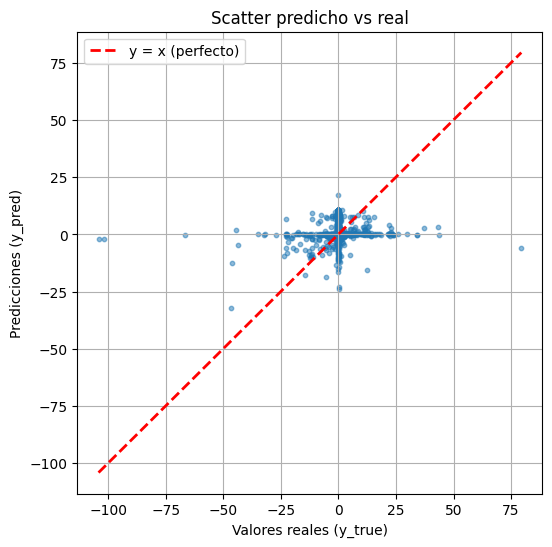

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_true_all, y_pred_all, alpha=0.5, s=10)
plt.plot([y_true_all.min(), y_true_all.max()],
         [y_true_all.min(), y_true_all.max()],
         "r--", lw=2, label="y = x (perfecto)")
plt.xlabel("Valores reales (y_true)")
plt.ylabel("Predicciones (y_pred)")
plt.title("Scatter predicho vs real")
plt.legend()
plt.grid(True)
plt.show()
